# Part B.

## Imports and Setup

In [ ]:
!pip install transformers

In [ ]:
from transformers import BertModel, BertTokenizer
import nltk
import torch
import torch.nn as nn
import numpy as np
import random
import re
import pandas as pd
from scipy.stats import norm
import math
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
# If you have your folder of data on your Google drive account, you can connect that here
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Change this to the directory with your data
directory="/content/drive/MyDrive/AP5"

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on {}".format(device))

Running on cuda


In [ ]:
def read_labels(filename):
    labels={}
    with open(filename) as file:
        for line in file:
            cols = line.split("\t")
            label = re.sub("(\\n)", "", cols[1])
            if label not in labels:
                labels[label]=len(labels)
    return labels

In [ ]:
def read_data(filename, labels, max_data_points=1000):

    data = []
    data_labels = []
    with open(filename) as file:
        for line in file:
            cols = line.split("\t")
            label = re.sub("(\\n)", "", cols[1])
            text = cols[0]

            data.append(text)
            data_labels.append(labels[label])



    # shuffle the data
    tmp = list(zip(data, data_labels))
    random.shuffle(tmp)
    data, data_labels = zip(*tmp)

    if max_data_points is None:
        return data, data_labels

    return data[:max_data_points], data_labels[:max_data_points]

In [ ]:
labels=read_labels("%s/train.tsv" % directory)
print(labels)

{'Anti-joke': 0, 'Dry': 1, 'Mockery': 2, 'Random/Absurd': 3, 'Satire/Parody': 4, 'Wordplay': 5}


In [ ]:
train_x, train_y=read_data("%s/train.tsv" % directory, labels, max_data_points=None)

In [ ]:
dev_x, dev_y=read_data("%s/dev.tsv" % directory, labels, max_data_points=None)

In [ ]:
test_x, test_y=read_data("%s/test.tsv" % directory, labels, max_data_points=None)

## Creating the Model/Functions

In [ ]:
def evaluate(model, x, y):
    model.eval()
    corr = 0.
    total = 0.
    with torch.no_grad():
        for x, y in zip(x, y):
            y_preds=model.forward(x)
            for idx, y_pred in enumerate(y_preds):
                prediction=torch.argmax(y_pred)
                if prediction == y[idx]:
                    corr += 1.
                total+=1
    return corr/total, total

In [ ]:
class BERTClassifier(nn.Module):

    def __init__(self, bert_model_name, params):
        super().__init__()

        self.model_name=bert_model_name
        self.tokenizer = BertTokenizer.from_pretrained(self.model_name, do_lower_case=params["doLowerCase"], do_basic_tokenize=False)
        self.bert = BertModel.from_pretrained(self.model_name)

        self.num_labels = params["label_length"]

        self.fc = nn.Linear(params["embedding_size"], self.num_labels)

    def get_batches(self, all_x, all_y, batch_size=64, max_toks=512):

        """ Get batches for input x, y data, with data tokenized according to the BERT tokenizer
      (and limited to a maximum number of WordPiece tokens """

        batches_x=[]
        batches_y=[]

        for i in range(0, len(all_x), batch_size):

            current_batch=[]

            x=all_x[i:i+batch_size]

            batch_x = self.tokenizer(x, padding=True, truncation=True, return_tensors="pt", max_length=max_toks)
            batch_y=all_y[i:i+batch_size]

            batches_x.append(batch_x.to(device))
            batches_y.append(torch.LongTensor(batch_y).to(device))

        return batches_x, batches_y


    def forward(self, batch_x):

        bert_output = self.bert(input_ids=batch_x["input_ids"],
                         attention_mask=batch_x["attention_mask"],
                         token_type_ids=batch_x["token_type_ids"],
                         output_hidden_states=True)

      # We're going to represent an entire document just by its [CLS] embedding (at position 0)
      # And use the *last* layer output (layer -1)
      # as a result of this choice, this embedding will be optimized for this purpose during the training process.

        bert_hidden_states = bert_output['hidden_states']

        out = bert_hidden_states[-1][:,0,:]

        out = self.fc(out)

        return out.squeeze()

In [ ]:
def confidence_intervals(accuracy, n, significance_level):
    critical_value=(1-significance_level)/2
    z_alpha=-1*norm.ppf(critical_value)
    se=math.sqrt((accuracy*(1-accuracy))/n)
    return accuracy-(se*z_alpha), accuracy+(se*z_alpha)

In [ ]:
def train(bert_model_name, model_filename, train_x, train_y, dev_x, dev_y, labels, embedding_size=768, doLowerCase=None):

    bert_model = BERTClassifier(bert_model_name, params={"label_length": len(labels), "doLowerCase":doLowerCase, "embedding_size":embedding_size})
    bert_model.to(device)

    batch_x, batch_y = bert_model.get_batches(train_x, train_y)
    dev_batch_x, dev_batch_y = bert_model.get_batches(dev_x, dev_y)

    optimizer = torch.optim.Adam(bert_model.parameters(), lr=0.00005)
    cross_entropy=nn.CrossEntropyLoss()

    num_epochs=50
    best_dev_acc = 0.
    patience=5

    best_epoch=0

    for epoch in range(num_epochs):
        bert_model.train()

        # Train
        for x, y in zip(batch_x, batch_y):
            y_pred = bert_model.forward(x)
            loss = cross_entropy(y_pred.view(-1, bert_model.num_labels), y.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Evaluate
        dev_accuracy, _=evaluate(bert_model, dev_batch_x, dev_batch_y)
        if epoch % 1 == 0:
            print("Epoch %s, dev accuracy: %.3f" % (epoch, dev_accuracy))
            if dev_accuracy > best_dev_acc:
                torch.save(bert_model.state_dict(), model_filename)
                best_dev_acc = dev_accuracy
                best_epoch=epoch
        if epoch - best_epoch > patience:
            print("No improvement in dev accuracy over %s epochs; stopping training" % patience)
            break

    bert_model.load_state_dict(torch.load(model_filename))
    print("\nBest Performing Model achieves dev accuracy of : %.3f" % (best_dev_acc))
    return bert_model


## Training and Evaluating The model

In [ ]:
# small BERT -- can run on laptop
# bert_model_name="google/bert_uncased_L-2_H-128_A-2"
# model_filename="mybert.model"
# embedding_size=128
# doLowerCase=True

# bert-base -- slow on laptop; better on Colab
bert_model_name="bert-base-cased"
model_filename="mybert.model"
embedding_size=768
doLowerCase=True

model=train(bert_model_name, model_filename, train_x, train_y, dev_x, dev_y, labels, embedding_size=embedding_size, doLowerCase=doLowerCase)

Epoch 0, dev accuracy: 0.160
Epoch 1, dev accuracy: 0.170
Epoch 2, dev accuracy: 0.210
Epoch 3, dev accuracy: 0.300
Epoch 4, dev accuracy: 0.350
Epoch 5, dev accuracy: 0.220
Epoch 6, dev accuracy: 0.320
Epoch 7, dev accuracy: 0.230
Epoch 8, dev accuracy: 0.300
Epoch 9, dev accuracy: 0.310
Epoch 10, dev accuracy: 0.280
No improvement in dev accuracy over 5 epochs; stopping training

Best Performing Model achieves dev accuracy of : 0.350


In [ ]:
test_batch_x, test_batch_y = model.get_batches(test_x, test_y)
accuracy, test_n=evaluate(model, test_batch_x, test_batch_y)

lower, upper=confidence_intervals(accuracy, test_n, .95)
print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))

Test accuracy for best dev model: 0.310, 95% CIs: [0.219 0.401]



# Part C.

The highest achieved test accuracy (`0.400, 95% CIs: [0.304 0.496]`) was lower than we desired. However, after testing around with the BERT model ourselves, we ended up agreeing with the model's humor classification for the jokes we wrote ourselves. Here are some examples below…


In [ ]:
def classify_text(model, text, label_map):
    model.eval()
    tokenizer = model.tokenizer

    batch = tokenizer([text], padding=True, truncation=True, return_tensors="pt", max_length=510).to(device)

    with torch.no_grad():
        output = model(batch)
        predicted_class_id = torch.argmax(output).item()

    id_to_label = {v: k for k, v in label_map.items()}
    predicted_label = id_to_label[predicted_class_id]

    return predicted_label


def classify_text_n(model, data):
  """
     Takes in:
        -model
        -data (a list of strings to classify)
     Outputs:
        -List of classifications
  """
  predictions = []
  for x in data:
    predictions.append(classify_text(model, x, labels))
  return np.array(predictions)


In [ ]:
sample_text = "What do you call a cow with no legs? Ground beef"
predicted_label = classify_text(model, sample_text, labels)
print("Joke:", sample_text)
print("Predicted label:", predicted_label)
sample_text = "You've only got two brain cells, and they're both fighting for third place"
predicted_label = classify_text(model, sample_text, labels)
print("Joke:", sample_text)
print("Predicted label:", predicted_label)
sample_text = "My favorite mythical creature? The honest politician."
predicted_label = classify_text(model, sample_text, labels)
print("Joke:", sample_text)
print("Predicted label:", predicted_label)

Joke: What do you call a cow with no legs? Ground beef
Predicted label: Wordplay
Joke: You've only got two brain cells, and they're both fighting for third place
Predicted label: Mockery
Joke: My favorite mythical creature? The honest politician.
Predicted label: Satire/Parody


## What kind of systematic mistakes did our model make?

In addition to the small number of documents in our dataset, one reason for our models under-performance (high bias and high variance between models) could be the unbalanced number of jokes for each type in our dataset, as seen below.

In [ ]:
pandas_train = pd.read_csv('/content/drive/MyDrive/AP5/RawJokeSheet.csv')

Text(0.5, 1.0, 'Total Number of Jokes by Label')

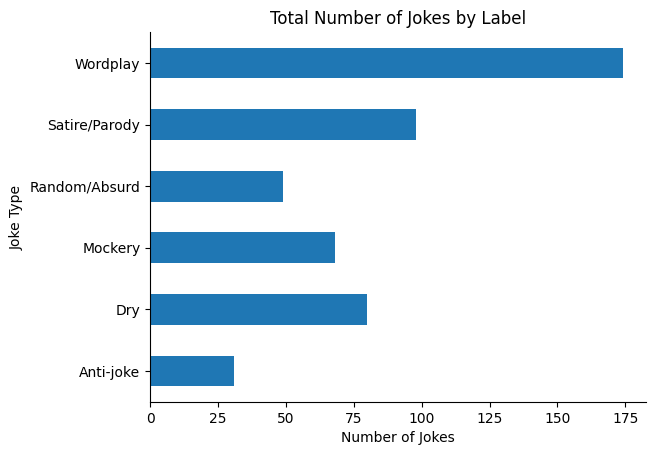

In [ ]:
pandas_train.groupby('Label').size().plot(kind='barh')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xlabel("Number of Jokes")
plt.ylabel("Joke Type")
plt.title("Total Number of Jokes by Label")

A direct effect of this is our model leaning largely towards predicting `Wordplay`, even in the case of an empty string.

In [ ]:
sample_text = ""
predicted_label = classify_text(model, sample_text, labels)
print("Joke:", sample_text)
print("Predicted label:", predicted_label)

Joke: 
Predicted label: Wordplay


Lets take a look at our models predictions in the test set:

In [ ]:
test_predictions = pd.DataFrame(data= {"Predicted": classify_text_n(model, test_x), "Actual": test_y})
inverse_labels = {v: k for k, v in labels.items()}
test_predictions['Actual'] = test_predictions['Actual'].map(inverse_labels)
test_predictions['Correct'] = test_predictions['Predicted'] == test_predictions['Actual']
test_predictions

,Predicted,Actual,Correct
0,Dry,Dry,True
1,Wordplay,Wordplay,True
2,Satire/Parody,Mockery,False
3,Wordplay,Wordplay,True
4,Dry,Wordplay,False
...,...,...,...
95,Mockery,Mockery,True
96,Satire/Parody,Dry,False
97,Wordplay,Wordplay,True
98,Wordplay,Anti-joke,False


Let's see what joke types (according to the *`true`* label) were most typically correct. *`size`* is the number of that type of joke in the test set, while *`mean`* is the percent correct.



In [ ]:
test_predictions_grouped = test_predictions.groupby('Actual')['Correct'].agg(["size", "mean"])
test_predictions_grouped

,size,mean
Actual,,
Anti-joke,4,0.000000
Dry,25,0.240000
Mockery,19,0.210526
Random/Absurd,9,0.111111
Satire/Parody,17,0.470588
Wordplay,26,0.461538


<ipython-input-166-d7f7209c5924>:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  temp.set_xticklabels(agreePlot.get_xticklabels(), fontsize=7);


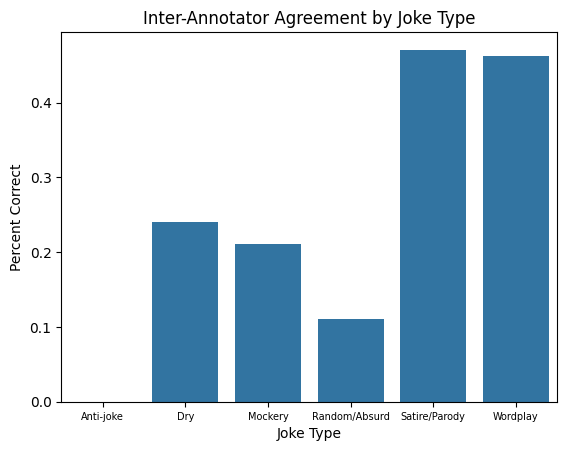

In [ ]:
temp = sns.barplot(data = test_predictions_grouped, y = 'mean', x='Actual', orient='v');
plt.title("Model Accuracy by Joke Type")
plt.xlabel("Joke Type")
plt.ylabel("Percent Correct");
temp.set_xticklabels(agreePlot.get_xticklabels(), fontsize=7);

It is evident that our model is unable to accurately predict joke types that are not `Satire/Parody` or `Wordplay`. To prevent this in future projects, we would likely try to find more data for the underrepresented joke categories in our dataset.

## How does the model compare to overall annotator agreement?

The model performed poorly on the testing data, however let's examine how good it could possibly be given our task and annotated data. To look into this, let's establish somewhat of a human baseline that we can compare our model to. Below we perform a simple operation: calculate the percentage of the time the 2 annotators for each question agree. This works out to be 48% of the time.

In [ ]:
def annotator_agreement(row):
    annotators = [row['Wills'], row['Andrew'], row['Brandon'], row['Jake']]
    labels = [label for label in annotators if pd.notna(label)]
    return labels[0] == labels[1]

ae = pd.read_csv('/content/drive/MyDrive/AP5/RawJokeSheet.csv')
annotators = ['Wills', 'Andrew', 'Brandon', 'Jake']

ae["agree"] = ae.apply(annotator_agreement, axis=1)

In [ ]:
print(f"Percent of the time the annotators agreed: {float(np.mean(ae['agree']))}")

Percent of the time the annotators agreed: 0.48


Lets explore the categories that had the highest agreement percentage.

<ipython-input-136-971ae3850bd7>:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  agreePlot.set_xticklabels(agreePlot.get_xticklabels(), fontsize=7);


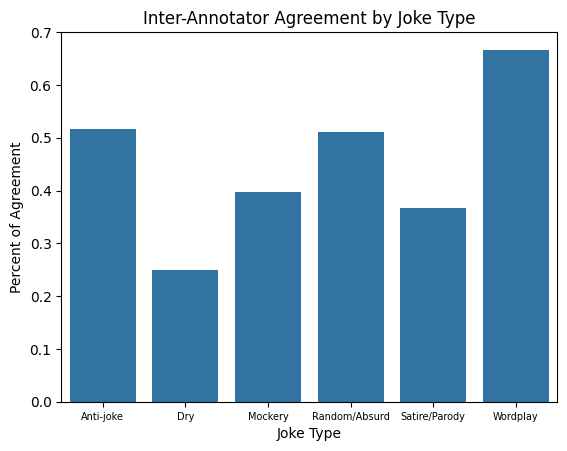

In [ ]:
aeg = ae.groupby('Label')[['agree']].mean()
aeg
agreePlot = sns.barplot(data = aeg, y = 'agree', x='Label', orient='v');
agreePlot.set_xticklabels(agreePlot.get_xticklabels(), fontsize=7);
plt.title("Inter-Annotator Agreement by Joke Type")
plt.xlabel("Joke Type")
plt.ylabel("Percent of Agreement");
# sns.violinplot(data = ae, x = 'agree', hue='Label')

As seen in the visualization above, some categories had a much smaller inter-annotator agreement percentage, which could mean that our guidelines were not explicit enough when describing these categories. 'Wordplay' and 'Anti-joke' had the highest percentage of agreement, while 'Dry' and 'Satire' had the lowest. It should be noted that the joke type chosen for the x axis is the final, adjudicated label.